## TIMIT-derived datasets

We combina data from 2 datasets:
- TIMIT: wav
- VTRFormants: manually verified F1-3 tracks (though interpolated). A subset of TIMIT. 324 train files, 192 test files.

We can't use TIMIT-voiced (another TIMIT subset) to ensure that we are only looking at voiced speech because they only overlap in 10 samples. ~~So we use Praat's heuristics (the pulses) to determine whether there is voiced speech.~~ This is quite brittle because of boundary effects -- so we just use the phonetic information and only consider vowel events for simplicity (it's just a prior after all). In this we follow Mehta (2012), although much more restricted (they only filter out silence regions and accept consonants etc.)

### VTRFormants

Citing from the README file:

> Note that only the first three elements of these vectors (F1, F2, F3) are manually corrected.

Each frame is 10 msec.

> Note also that since interpolation was used, VTR/formant tracks are placed in silence intervals where no VTR exists. When evaluating formant trackers, these values should probably be excluded from the evaluation.

## Data cleaning

To simplify the analysis, we only compare formants during vowel events as identified by the original TIMIT database.

And we only run the Praat analysis (both pulses and formants) during these events to get clean estimates, because at the boundaries there can be strong jumps in Praat's F1-F3 formant tracks.

We also don't correct for Praat's $\hat T$ (has ~7% relative error) and thus take Praat's estimated pitch periods at face value.

We can evaluate formant tracks and ground truth anywhere (because they are both interpolated) -- maybe average them over the estimated pitch period interval.

## Results

Are the Praat errors comparable to Mehta (2012, Table III)'s results? We only measure over vowels so should be quite a bit lower.

In [1]:
%run init.ipy

from lib import htkio
from dgf import bijectors

from vtr import formant

2022-10-31 17:14:26.949730: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


[Memory]6.8s, 0.1min    : Loading get_aplawd_training_pairs...


[Memory]38.3s, 0.6min   : Loading run_nested...
[Memory]42.6s, 0.7min   : Loading run_nested...
[Memory]46.5s, 0.8min   : Loading run_nested...
[Memory]49.8s, 0.8min   : Loading run_nested...
[Memory]49.8s, 0.8min   : Loading get_aplawd_training_pairs...


In [2]:
from lib.timit import *

def rand_triple():
    vtr_root = training_set(VTRFORMANTS)
    timit_root = training_set(TIMIT)
    l = list(yield_file_triples(vtr_root, timit_root))
    import random
    return random.choice(l)

triple = rand_triple()
fb_file, phn_file, wav_file = triple
triple

(PosixPath('/home/marnix/WRK/thesis/py/../data/VTRFormants/TRAIN/DR6/MSAT1/SI1073.FB'),
 PosixPath('/home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.PHN'),
 PosixPath('/home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV'))

In [3]:
d, fs = formant.read_wav_file_and_normalize(wav_file)
t = np.arange(len(d))/fs

from lib import klatt
klatt.play(t*1000., d)

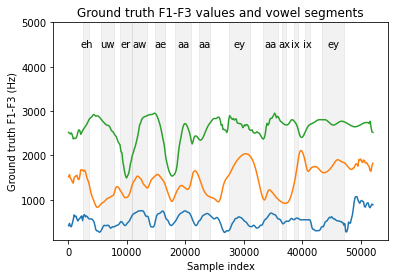

In [5]:
phn = formant.select_vowel_segments(phn_file)

def plot_vowel_segments(df, ytext):
    for start, end, label in phn.to_tuples():
        plt.axvspan(start, end, color="grey", alpha=.1)
        plt.text(start + (end - start)/2, ytext, label,
                 horizontalalignment='center',
                 verticalalignment='center')

plot_vowel_segments(phn, 4500.)
        
frame_midpoint_idx, F_true = formant.select_F_true(fb_file, fs)

plt.plot(frame_midpoint_idx, F_true)
xlabel("Sample index")
ylabel("Ground truth F1-F3 (Hz)")
title("Ground truth F1-F3 values and vowel segments")
ylim(100, 5000);

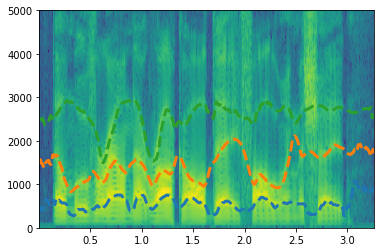

In [8]:
specgram(d, Fs=fs);
plot(frame_midpoint_idx/fs, F_true, '--', lw=3)
ylim(0, 5000);

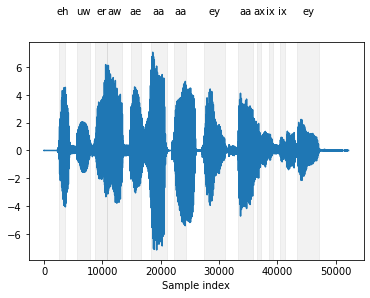

In [9]:
plot_vowel_segments(phn, 10)
plot(d)
xlabel("Sample index");

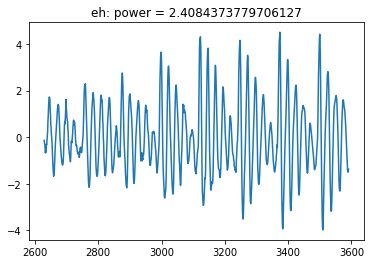

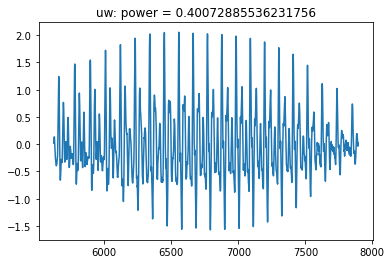

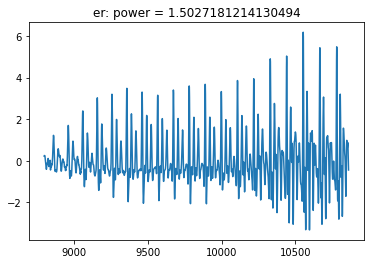

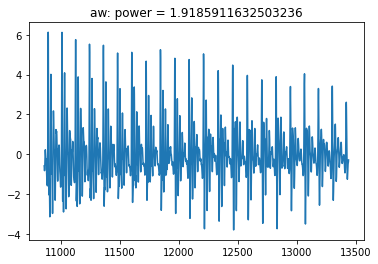

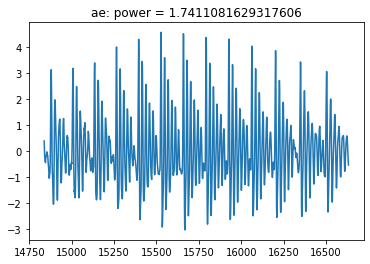

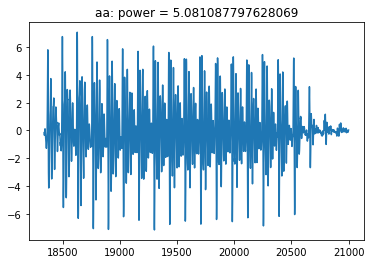

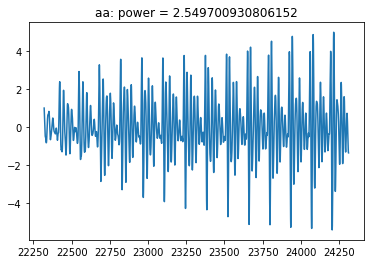

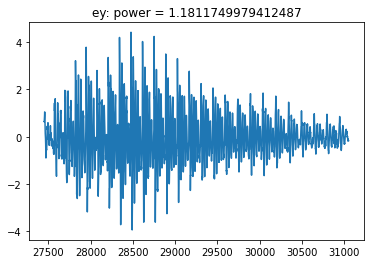

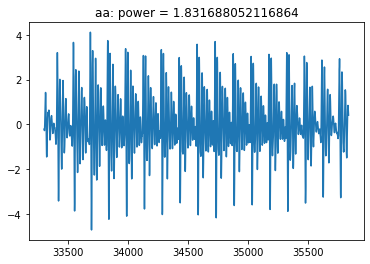

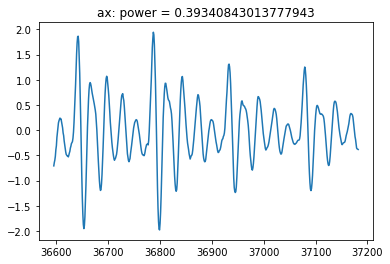

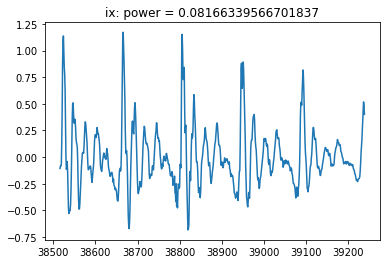

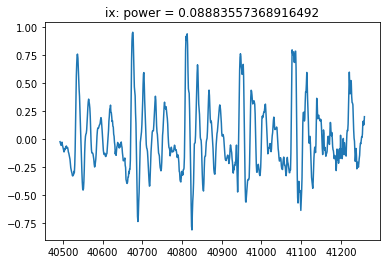

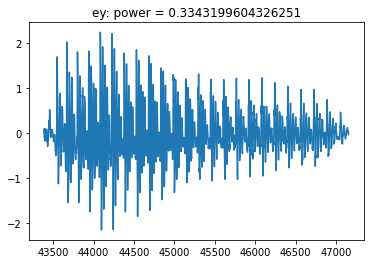

In [10]:
# Locally the power may vary, but we renormalize anyway so it doesnt matter
for start, end, label in phn.to_tuples():
    idx = range(start, end)
    segment = d[idx]
    plot(idx, segment)
    power = np.sum(segment**2)/len(segment)
    title(f'{label}: power = {power}')
    show()

/home/marnix/WRK/thesis/py/vtr/formant.py:81: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `eh` segment at sample indices 2629:3592: Praat gave less than 3 valid formants
  )


**********uw**********


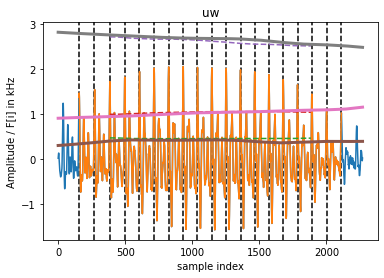

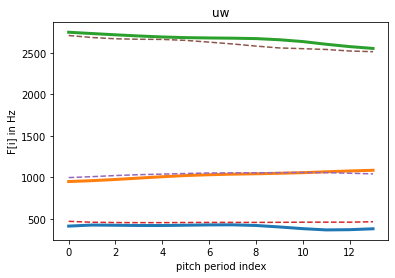

**********er**********


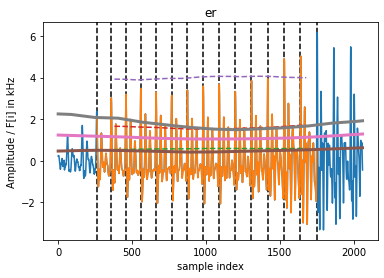

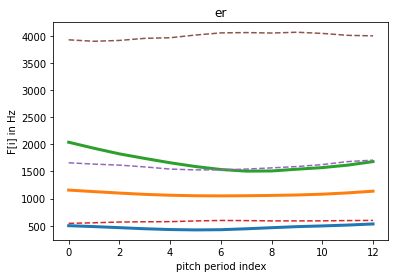

**********aw**********


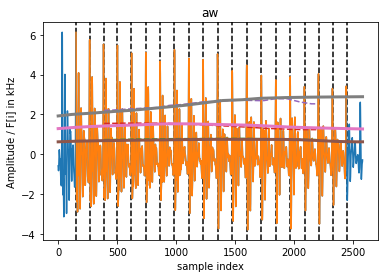

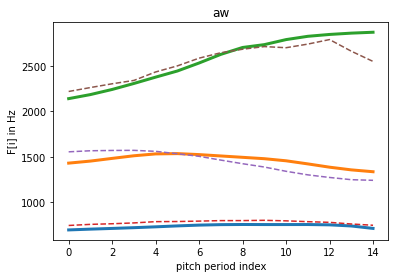

**********ae**********


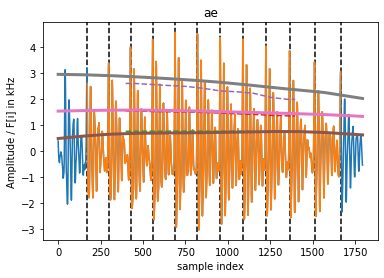

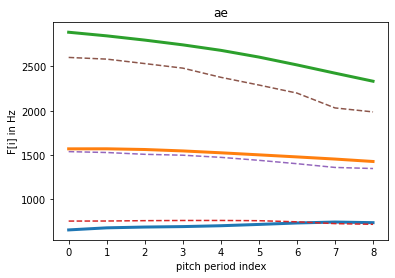

**********aa**********


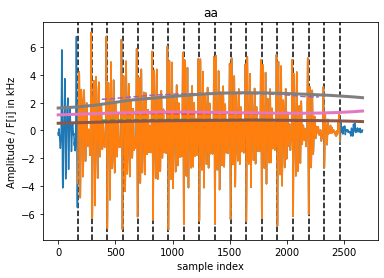

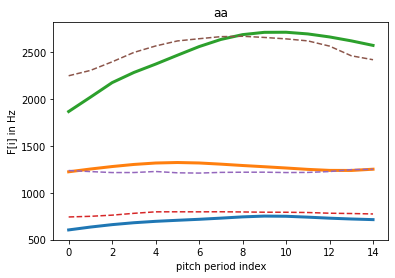

**********aa**********


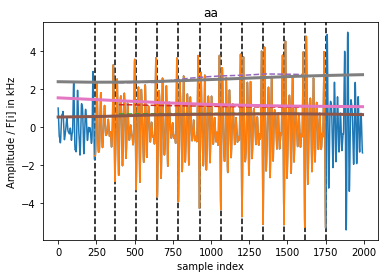

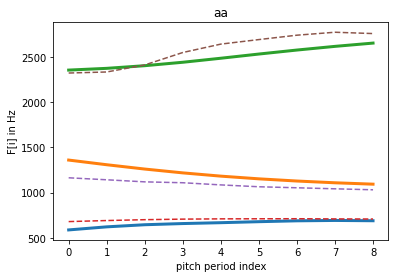

**********ey**********


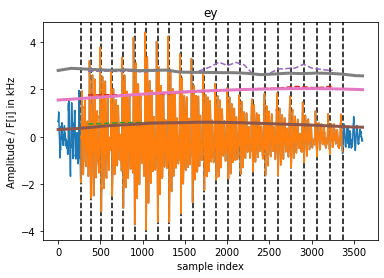

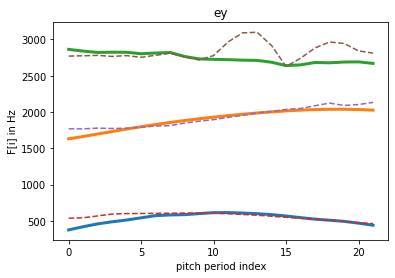

**********aa**********


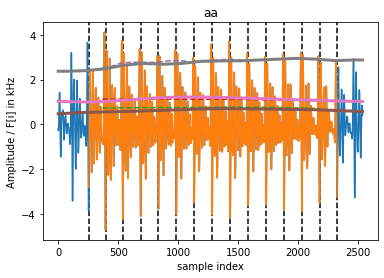

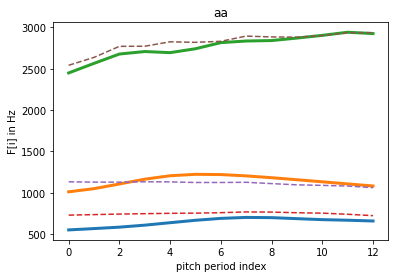

/home/marnix/WRK/thesis/py/vtr/formant.py:81: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ax` segment at sample indices 36595:37183: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 81.63265306122449 Hz.
Sound: pitch analysis not performed.
  )
/home/marnix/WRK/thesis/py/vtr/formant.py:81: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ix` segment at sample indices 38516:39240: Praat gave less than 3 valid formants
  )
/home/marnix/WRK/thesis/py/vtr/formant.py:81: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR6/MSAT1/SI1073.WAV: Discarding vowel `ix` segment at sample indices 40493:41260: Praat gave less than 3 valid formants
  )


**********ey**********


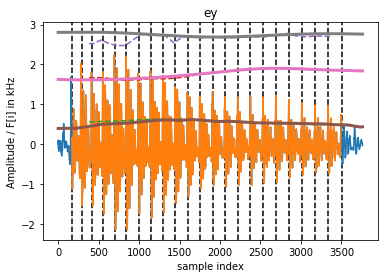

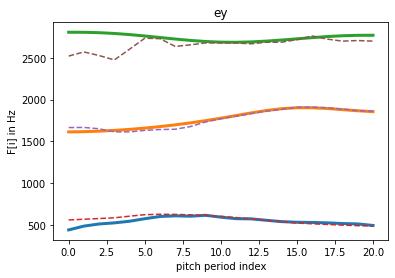

In [63]:
from dgf import constants

for F_true_periods, F_praat_periods, context in formant.yield_training_pairs(
        fb_file, phn_file, wav_file, return_full=True
    ):
    vowel = context['vowel']
    print("*"*10 + vowel + "*"*10)
    
    # Plot pulse estimates
    pulse_idx = context['pulse_idx']
    for pi in pulse_idx:
        axvline(pi, ls="--", color="black")
    first, last = pulse_idx[0], pulse_idx[-1]
    
    # Plot waveform
    segment = context['segment']
    plot(segment)
    plot(range(first, last), segment[first:last])
    
    # Plot formant tracks
    plot(context['F_praat_tracks']/1000, "--")
    plot(context['F_true_tracks']/1000, lw=3)
    ylabel("Amplitude / F[i] in kHz")
    xlabel("sample index")
    title(vowel)
    show()
    
    # Plot the distilled training data
    plot(F_true_periods, lw=3)
    plot(F_praat_periods, "--")
    ylabel("F[i] in Hz")
    xlabel("pitch period index")
    title(vowel)
    show()

In [81]:
%%time
training_pairs = formant.get_vtrformants_training_pairs()

________________________________________________________________________________
[Memory] Calling vtr.formant.get_vtrformants_training_pairs...
get_vtrformants_training_pairs()


/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SI1320.WAV: Discarding vowel `ax` segment at sample indices 26830:27400: segment too short for Praat's pulse estimation algorithm: To analyse this Sound, “minimum pitch” must not be less than 84.21052631578947 Hz.
Sound: pitch analysis not performed.
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SI1320.WAV: Discarding vowel `eh` segment at sample indices 42210:44440: Estimated Praat periods not within `{min|max}_period_length_msec`: [7.25   7.375  7.3125 7.4375 7.4375 7.4375 7.5625 7.5625 7.625  7.8125
 7.8125 2.0625 1.9375 1.8125 3.5    1.9375 1.9375 2.0625 1.8125 1.9375
 2.     1.9375]
  warnings.warn(
/home/marnix/WRK/thesis/py/vtr/formant.py:82: UserWarning: /home/marnix/WRK/thesis/py/../data/TIMIT/TRAIN/DR5/MWEM0/SX240.WAV: Discarding vowel `ix` segment at sample indices 2320:3043:

_________________________________get_vtrformants_training_pairs - 102.8s, 1.7min
CPU times: user 4min 20s, sys: 56.7 s, total: 5min 16s
Wall time: 1min 42s


In [83]:
len(training_pairs)

3094

In [89]:
true_F_trajectories = [p[0] for p in training_pairs]

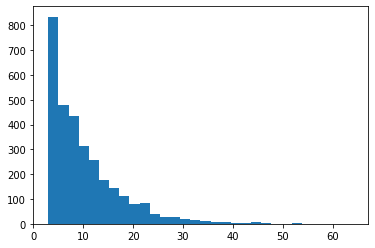

In [93]:
hist([sample.shape[0] for sample in true_F_trajectories], bins=30);

In [97]:
bounds = jnp.array([
    (100., 5000.),
    (100., 5000.),
    (100., 5000.)
])

bounds

DeviceArray([[ 100., 5000.],
             [ 100., 5000.],
             [ 100., 5000.]], dtype=float64)

In [ ]:
bijector, results = bijectors.fit_nonlinear_coloring_trajectory_bijector(
    true_F_trajectories, bounds, "Matern32Kernel", 111111, return_fit_results=True
)

________________________________________________________________________________
[Memory] Calling dgf.bijectors.run_nested...
run_nested(111111, {'nlive': 25}, {'save_bounds': False})
Exception while calling loglikelihood function:
  params: [0.42582812 1.09747939 2.24190951 1.39323461 0.58366199]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/dynesty/dynesty.py", line 1027, in __call__
    return self.func(x.copy(), *self.args, **self.kwargs)
  File "/home/marnix/WRK/thesis/py/dgf/bijectors.py", line 290, in loglike
    logprob = np.sum([loglike_batch(x, batch) for batch in batches])
  File "/home/marnix/WRK/thesis/py/dgf/bijectors.py", line 290, in <listcomp>
    logprob = np.sum([loglike_batch(x, batch) for batch in batches])
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/jax/_src/traceback_util.py", line 162, in reraise_with_filtered_traceback
    return fun(*args, **kwargs)
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/jax/_src/api.py", line 606, in cache_miss
    out_flat = xla.xla_call(
  File "/home/marnix/WRK/thesis/py/venv/lib/python3.8/site-packages/jax/core.py", line 1939, in bind
    return call_bind(self, fun, *args, **params)
  File "/home/marnix/WRK/thesis/py/venv/l